<a href="https://colab.research.google.com/github/SelinErcan/MachineLearning/blob/main/Experiments_with_KNN_SVM_DT_on_Bank_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Load Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import KFold 
from sklearn import  datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score 
from sklearn import metrics
from sklearn import svm
import pylab as pl
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KDTree
from sklearn.datasets import make_classification 
import math
import operator
from datetime import datetime
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import scikitplot as skplt
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sn
import pickle

from google.colab import drive
drive.mount('/content/drive')

np.set_printoptions(suppress=True)  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Datasets


In [ ]:
# Read Data
bank_dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Machine Learning/HW1/bank_marketing/bank-full.csv', sep=";")

In [ ]:
bank_dataset

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


**I used LabelEncoder for categorical features.**

In [ ]:
le = LabelEncoder()
categorical_labels = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact','month', 'poutcome', 'y']
for label in categorical_labels:
    bank_dataset[label] = le.fit_transform(bank_dataset[label])


In [ ]:
bank_dataset

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,9,1,2,0,825,0,0,0,17,9,977,3,-1,0,3,1
45207,71,5,0,0,0,1729,0,0,0,17,9,456,2,-1,0,3,1
45208,72,5,1,1,0,5715,0,0,0,17,9,1127,5,184,3,2,1
45209,57,1,1,1,0,668,0,0,1,17,9,508,4,-1,0,3,0


**I undersampled class 0 ("no") because there was an imbalance between class "yes" and class "no".**

In [ ]:
print("Class no count :", bank_dataset[bank_dataset['y']==0]['y'].count())

Class no count : 39922


In [ ]:
least_size = bank_dataset[bank_dataset['y']==1]['y'].count()
print("Class yes count :", least_size)

Class yes count : 5289


In [ ]:
# select random samples from class 0 within the size of class 1
bank_dataset = pd.concat([bank_dataset[bank_dataset['y']==0].sample(least_size), bank_dataset[bank_dataset['y']==1]])
bank_dataset = shuffle(bank_dataset) 

**Normaliation**

In [ ]:
cols_to_norm = bank_dataset.columns[:-1]
print(cols_to_norm)
bank_dataset[cols_to_norm] = MinMaxScaler().fit_transform(bank_dataset[cols_to_norm])

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome'],
      dtype='object')


In [ ]:
bank_dataset

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
44619,0.129870,0.363636,1.0,0.666667,0.0,0.055048,1.0,0.0,0.0,0.000000,1.000000,0.057202,0.025,0.000000,0.000000,1.000000,1
27175,0.181818,0.636364,0.5,0.666667,0.0,0.039591,0.0,0.0,0.0,0.666667,0.818182,0.020613,0.000,0.000000,0.000000,1.000000,0
42674,0.532468,0.636364,1.0,0.333333,0.0,0.046802,0.0,0.0,0.0,0.433333,0.363636,0.105128,0.000,0.000000,0.000000,1.000000,1
9153,0.545455,0.090909,0.5,0.333333,0.0,0.040283,0.0,0.0,1.0,0.133333,0.545455,0.047668,0.000,0.000000,0.000000,1.000000,0
44623,0.181818,0.000000,0.5,0.333333,0.0,0.041542,0.0,0.0,0.0,0.000000,1.000000,0.187838,0.000,0.035088,0.051724,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38706,0.337662,0.363636,1.0,0.333333,0.0,0.075541,1.0,0.0,0.0,0.466667,0.727273,0.007988,0.100,0.210526,0.051724,0.000000,0
44249,0.220779,0.000000,1.0,0.333333,0.0,0.042723,0.0,0.0,0.0,0.666667,0.454545,0.036846,0.000,0.483041,0.051724,0.333333,1
39025,0.090909,0.363636,0.5,0.666667,0.0,0.037229,1.0,1.0,0.0,0.566667,0.727273,0.154599,0.075,0.389474,0.068966,0.333333,1
33974,0.493506,0.363636,0.5,0.666667,0.0,0.045602,0.0,0.0,0.0,0.966667,0.000000,0.057975,0.000,0.098246,0.017241,0.666667,1


# KNN

## Distances

In [ ]:
#Euclidean distance function
def euclideanDistance(instance1, instance2, length):
    distance = 0
    for x in range(length):
        distance += pow((instance1[x] - instance2[x]), 2)
    return math.sqrt(distance)

In [ ]:
#manhattan distance function
def manhattanDistance(instance1, instance2, length):
    distance = 0
    subResult = 0
    for x in range(length):
        subResult = instance1[x] - instance2[x]
        if (subResult < 0):
            distance += 0 - subResult
        else:
            distance += subResult
    return distance

## Custom KNN Classifier

In [ ]:
#KNN Classifier
def getNeighbors(trainingSet,testValue,k,disIndex):  #finds k=5 nearerst neighbors for given test value.
    distance = 0
    distances = [] 
    neighbors = []
    length = len(testValue)
    for x in range ( len ( trainingSet )):  #depends on the disIndex it uses eucladean distance or manhattan distance
        if disIndex == 0 :
            distance = euclideanDistance(testValue, trainingSet[x], length)
        if disIndex == 1 :
            distance = manhattanDistance(testValue, trainingSet[x], length)
        distances.append((x, distance))   #
        
    distances.sort(key=operator.itemgetter(1))    #sorts distances
    
    for x in range(k):      # gets the first k elemnts of distances and adds to neihbors array
        neighbors.append(distances[x][0])  #gets index value by increasing row value without distance value

    return neighbors


def getResult(neighbors,Y_train):   #with neigbors index value, neighbors class names are taken from Y_train. 
    classVotes = {}
    for x in range(len(neighbors)):
        index = neighbors[x]
        response = Y_train[index]
        if response in classVotes:    #classvotes shows the class names and how many niegbors are in the spesific class
            classVotes[response] += 1  #if there is already same class in classvotes, just increase the vote value
        
        else:
            classVotes[response] = 1  #if the class name couldn't find in the classvotes it creates class name and votes 1.
            
    sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)  #sort by their vote value
    return sortedVotes [0][0]


            
def knnClassifier(dataset,disIndex):

    array = dataset.values   
    X = array[:,0:-1]
    Y = array[:,-1] 
    
    totalAccuracy = 0
    totalPrecision = 0
    totalRecall = 0
    totalf1 = 0
    
    kf = KFold(n_splits=5, random_state=None, shuffle=True) #k-fold cross validation with value 10.
    split = kf.get_n_splits(X)
    print(kf) 
    
    for train_index, test_index in kf.split(X):   #splits the data to train and test data by given k value.
        
        X_train, X_test = X[train_index], X[test_index]   
        Y_train, Y_test = Y[train_index], Y[test_index]

    
        k = 5
        predictions=[]
        
        for x in range(len(X_test)):
            
            neighbors = getNeighbors(X_train, X_test[x], k, disIndex)  #get neighbors
            result = getResult(neighbors,Y_train)   #get predicted class 
            predictions.append(result)   
            
        confMatrix = confusion_matrix(Y_test, predictions)   #make confusion matrix by predictions and the true result
        
        df_cm = pd.DataFrame(confMatrix)
        plt.figure(figsize = (7,5))
        sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues') 
        plt.show()

        accuracy = accuracy_score(Y_test, predictions)  
        totalAccuracy += accuracy
        precision = precision_score(Y_test, predictions)  
        totalPrecision += precision
        recall = recall_score(Y_test, predictions)  
        totalRecall += recall
        f1 = f1_score(Y_test, predictions)  
        totalf1 += f1
        
        print('Accuracy: ' + repr(accuracy))
        print('Precision: ' + repr(precision))
        print('Recall: ' + repr(recall))
        print('F1: ' + repr(f1))
        print('\n------------------------------------------------------\n')
    
    
    print('Average Accuracy:'+repr(totalAccuracy/split))
    print('Average Precision:'+repr(totalPrecision/split))
    print('Average Recall:'+repr(totalRecall/split))
    print('Average F1:'+repr(totalf1/split))
 

## Part 1

KFold(n_splits=5, random_state=None, shuffle=True)


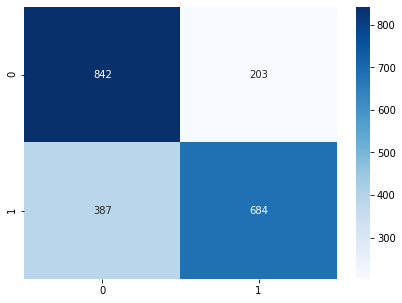

Accuracy: 0.72117202268431
Precision: 0.7711386696730552
Recall: 0.6386554621848739
F1: 0.6986721144024514

------------------------------------------------------



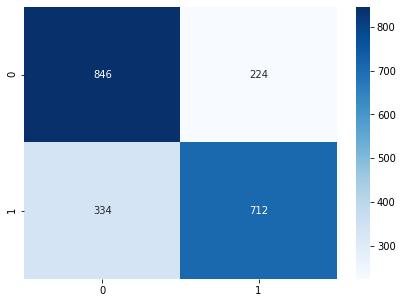

Accuracy: 0.7362948960302458
Precision: 0.7606837606837606
Recall: 0.6806883365200764
F1: 0.7184661957618566

------------------------------------------------------



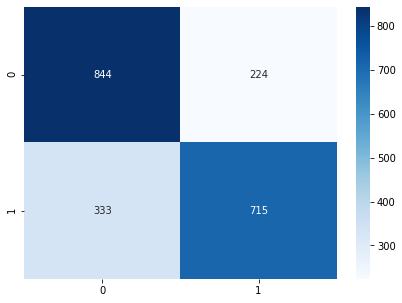

Accuracy: 0.7367674858223062
Precision: 0.7614483493077743
Recall: 0.6822519083969466
F1: 0.719677906391545

------------------------------------------------------



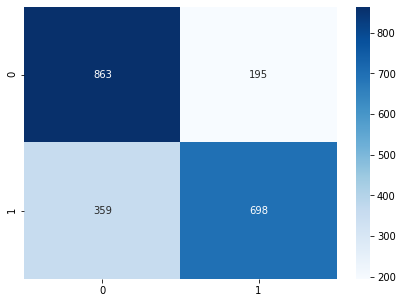

Accuracy: 0.7380614657210401
Precision: 0.7816349384098544
Recall: 0.6603595080416272
F1: 0.7158974358974359

------------------------------------------------------



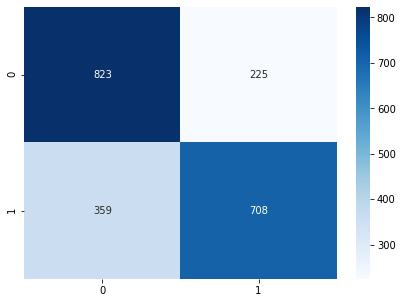

Accuracy: 0.7238770685579197
Precision: 0.7588424437299035
Recall: 0.6635426429240863
F1: 0.708

------------------------------------------------------

Average Accuracy:0.7312345877631643
Average Precision:0.7667496323608696
Average Recall:0.6650995716135221
Average F1:0.7121427304906577
Runtime Performance: 0:25:56.925964


In [ ]:
#implementation of KNN on the dataset with euclidean distance
start=datetime.now()  #for runtime performance, timer starts.
knnClassifier(bank_dataset,0)
print ("Runtime Performance:",datetime.now()-start) #sub the current time and start time to find runtime

## Part 2

KFold(n_splits=5, random_state=None, shuffle=True)


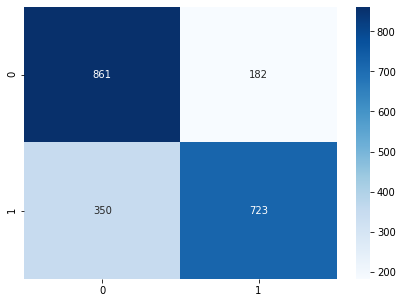

Accuracy: 0.7485822306238186
Precision: 0.7988950276243094
Recall: 0.67381174277726
F1: 0.7310414560161781

------------------------------------------------------



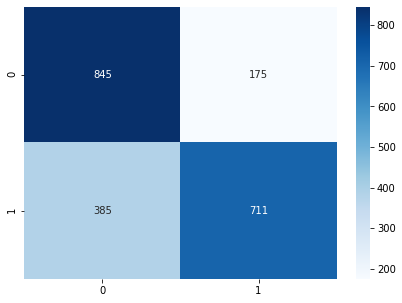

Accuracy: 0.7353497164461248
Precision: 0.8024830699774267
Recall: 0.6487226277372263
F1: 0.7174571140262362

------------------------------------------------------



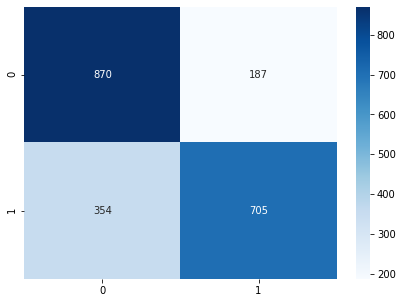

Accuracy: 0.744328922495274
Precision: 0.7903587443946188
Recall: 0.6657223796033994
F1: 0.7227063044592517

------------------------------------------------------



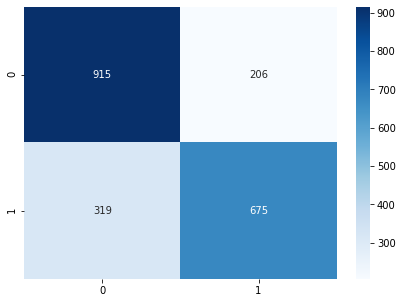

Accuracy: 0.75177304964539
Precision: 0.7661748013620885
Recall: 0.6790744466800804
F1: 0.72

------------------------------------------------------



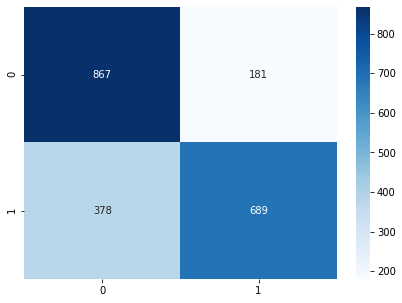

Accuracy: 0.7356973995271867
Precision: 0.7919540229885057
Recall: 0.6457357075913777
F1: 0.7114093959731543

------------------------------------------------------

Average Accuracy:0.7431462637475589
Average Precision:0.7899731332693898
Average Recall:0.6626133808778688
Average F1:0.7205228540949641
Runtime Performance: 0:25:21.877984


In [ ]:
#implementation of KNN on leaf dataset with manhattan distance
start=datetime.now()  #for runtime performance, timer starts.
knnClassifier(bank_dataset,1)
print ("Runtime Performance:",datetime.now()-start) #sub the current time and start time to find runtime

**Comments**

Manhattan distance have slightly better accuracy(%75) compared to euclidean distance(%73).

# SVM

## Part 3

In [ ]:
#Plotting roc curve function

def rocCurve(Y_test,y_score):  
    
    fpr, tpr, thresholds = roc_curve(Y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr) 
    pl.clf()
    pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    pl.plot([0, 1], [0, 1], 'k--')
    pl.xlim([0.0, 1.0])
    pl.ylim([0.0, 1.0])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title('Receiverrating characteristic example')
    pl.legend(loc="lower right")
    pl.show()

In [ ]:
#Linear SVM classification

def linearSVM(dataset):

    array = dataset.values   
    X = array[:,0:-1]
    Y = array[:,-1]
    
    totalAccuracy = 0
    totalPrecision = 0
    totalRecall = 0
    totalf1 = 0

    predictions = []    
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    split = kf.get_n_splits(X)
    print(kf) 
    
    for train_index, test_index in kf.split(X):
        
        
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        classifier = svm.SVC(kernel='linear', probability=True)   #To do multiclass-SVM,OneVsRestClassifier is used 
        y_score = classifier.fit(X_train, Y_train).predict_proba(X_test)  #the result of classification
        
        rocCurve(Y_test,y_score)  #to plot the roc curve for the result, rocCurve function is called

        y_predict_non_category = [ np.argmax(t) for t in y_score ]
        confMatrix = confusion_matrix(Y_test, y_predict_non_category)

        df_cm = pd.DataFrame(confMatrix)
        plt.figure(figsize = (7,5))
        sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='g') 
        plt.show()

        accuracy = accuracy_score(Y_test, y_predict_non_category)  
        totalAccuracy += accuracy
        precision = precision_score(Y_test, y_predict_non_category)  
        totalPrecision += precision
        recall = recall_score(Y_test, y_predict_non_category)  
        totalRecall += recall
        f1 = f1_score(Y_test, y_predict_non_category)  
        totalf1 += f1
        
        print('Accuracy: ' + repr(accuracy))
        print('Precision: ' + repr(precision))
        print('Recall: ' + repr(recall))
        print('F1: ' + repr(f1))
        print('\n------------------------------------------------------\n')
    
    
    print('Average Accuracy:'+repr(totalAccuracy/split))
    print('Average Precision:'+repr(totalPrecision/split))
    print('Average Recall:'+repr(totalRecall/split))
    print('Average F1:'+repr(totalf1/split))

KFold(n_splits=5, random_state=None, shuffle=True)


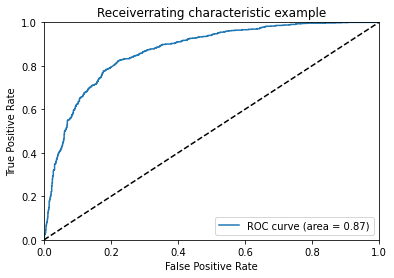

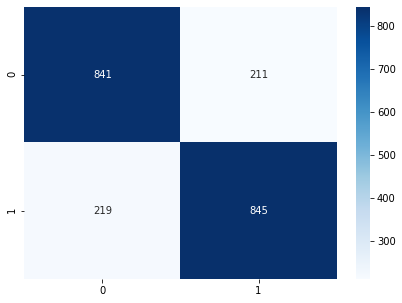

Accuracy: 0.7967863894139886
Precision: 0.8001893939393939
Recall: 0.7941729323308271
F1: 0.7971698113207548

------------------------------------------------------



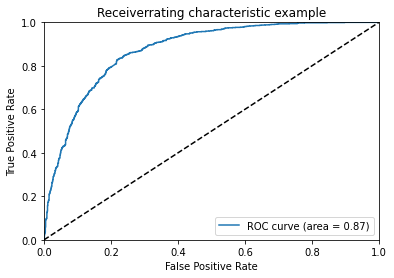

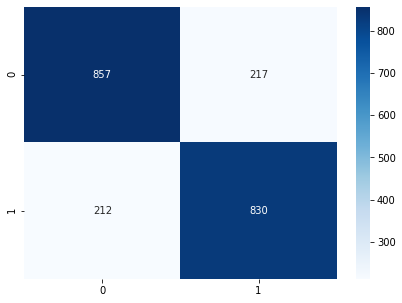

Accuracy: 0.7972589792060492
Precision: 0.792741165234002
Recall: 0.7965451055662188
F1: 0.7946385830540929

------------------------------------------------------



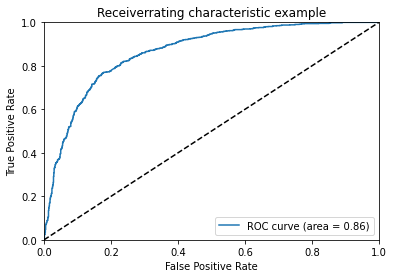

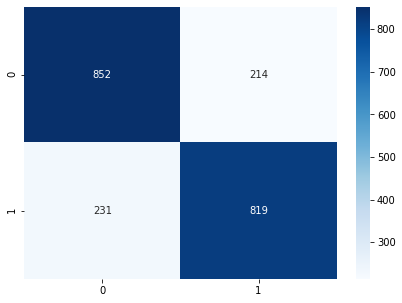

Accuracy: 0.7896975425330813
Precision: 0.7928363988383349
Recall: 0.78
F1: 0.7863658185309649

------------------------------------------------------



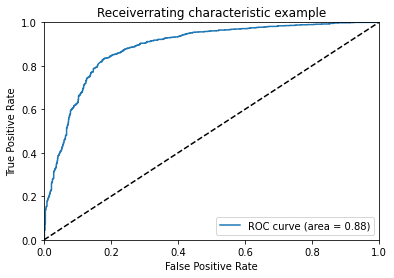

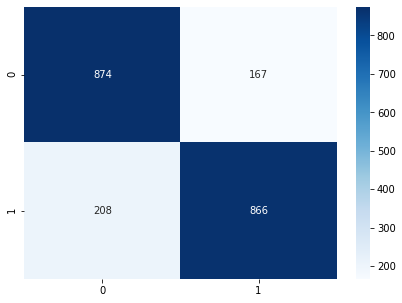

Accuracy: 0.8226950354609929
Precision: 0.8383349467570184
Recall: 0.8063314711359404
F1: 0.8220218319886092

------------------------------------------------------



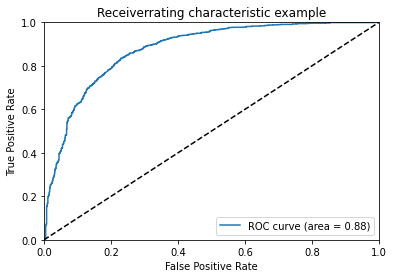

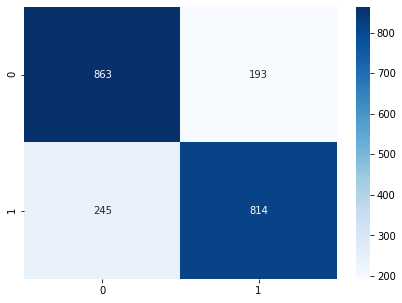

Accuracy: 0.7929078014184398
Precision: 0.8083416087388282
Recall: 0.7686496694995278
F1: 0.7879961277831559

------------------------------------------------------

Average Accuracy:0.7998691496065102
Average Precision:0.8064887027015153
Average Recall:0.7891398357065027
Average F1:0.7976384345355154
Runtime Performance: 0:00:50.309742


In [ ]:
#implementation of linear SVM on leaf dataset
start=datetime.now()  #for runtime performance, timer starts.
linearSVM(bank_dataset)
print ("Runtime Performance:",datetime.now()-start) #sub the current time and start time to find runtime

## Part 4

In [ ]:
#Polynomial SVM classification

def polynomialSVM(dataset):

    array = dataset.values   
    X = array[:,0:-1]
    Y = array[:,-1]
    
    totalAccuracy = 0
    totalPrecision = 0
    totalRecall = 0
    totalf1 = 0

    predictions = []    
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    split = kf.get_n_splits(X)
    print(kf) 
    
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        classifier = svm.SVC(kernel='rbf', probability=True)   #To do multiclass-SVM,OneVsRestClassifier is used 
        y_score = classifier.fit(X_train, Y_train).predict_proba(X_test)  #the result of classification
        
        rocCurve(Y_test,y_score)  #to plot the roc curve for the result, rocCurve function is called

        y_predict_non_category = [ np.argmax(t) for t in y_score ]
        confMatrix = confusion_matrix(Y_test, y_predict_non_category)

        df_cm = pd.DataFrame(confMatrix)
        plt.figure(figsize = (7,5))
        sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='g') 
        plt.show()

        accuracy = accuracy_score(Y_test, y_predict_non_category)  
        totalAccuracy += accuracy
        precision = precision_score(Y_test, y_predict_non_category)  
        totalPrecision += precision
        recall = recall_score(Y_test, y_predict_non_category)  
        totalRecall += recall
        f1 = f1_score(Y_test, y_predict_non_category)  
        totalf1 += f1
        
        print('Accuracy: ' + repr(accuracy))
        print('Precision: ' + repr(precision))
        print('Recall: ' + repr(recall))
        print('F1: ' + repr(f1))
        print('\n------------------------------------------------------\n')
    
    
    print('Average Accuracy:'+repr(totalAccuracy/split))
    print('Average Precision:'+repr(totalPrecision/split))
    print('Average Recall:'+repr(totalRecall/split))
    print('Average F1:'+repr(totalf1/split))
 

KFold(n_splits=5, random_state=None, shuffle=True)


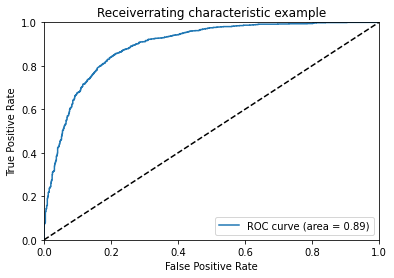

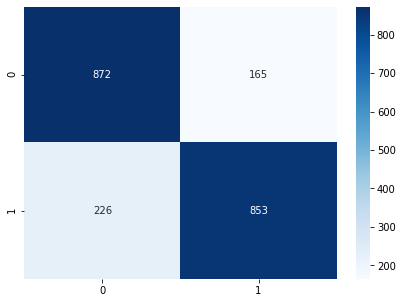

Accuracy: 0.8152173913043478
Precision: 0.8379174852652259
Recall: 0.7905468025949953
F1: 0.8135431568907964

------------------------------------------------------



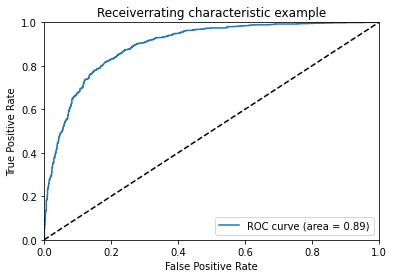

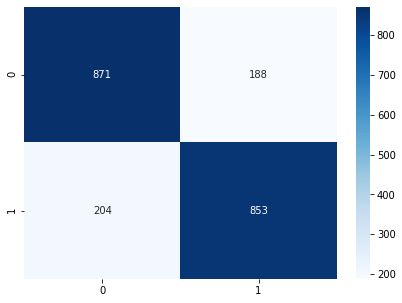

Accuracy: 0.8147448015122873
Precision: 0.8194044188280499
Recall: 0.8070009460737938
F1: 0.8131553860819829

------------------------------------------------------



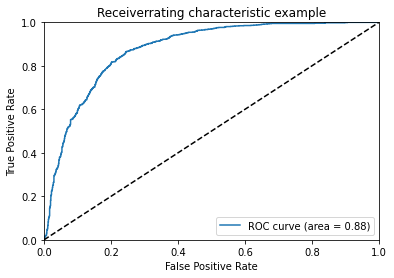

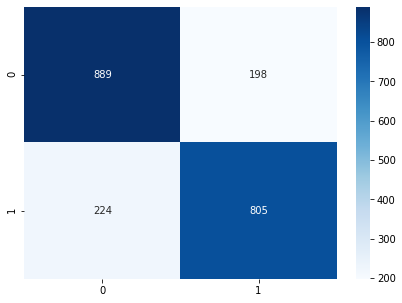

Accuracy: 0.8005671077504726
Precision: 0.80259222333001
Recall: 0.782312925170068
F1: 0.7923228346456693

------------------------------------------------------



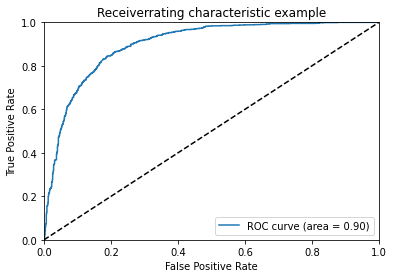

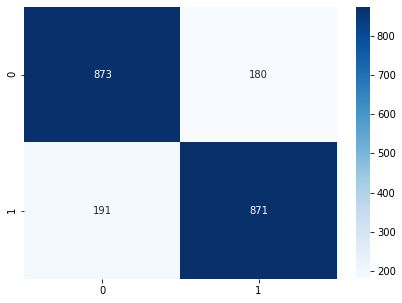

Accuracy: 0.8245862884160756
Precision: 0.8287345385347288
Recall: 0.82015065913371
F1: 0.8244202555608139

------------------------------------------------------



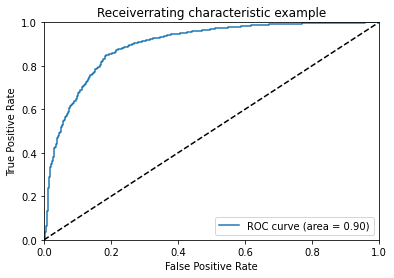

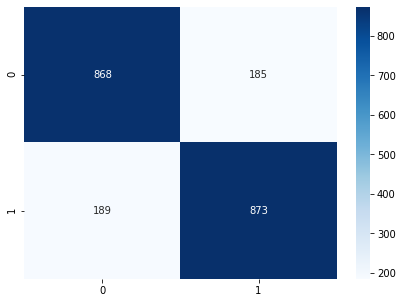

Accuracy: 0.8231678486997636
Precision: 0.8251417769376181
Recall: 0.8220338983050848
F1: 0.8235849056603775

------------------------------------------------------

Average Accuracy:0.8156566875365894
Average Precision:0.8227580885791266
Average Recall:0.8044090462555304
Average F1:0.813405307767928
Runtime Performance: 0:01:22.633216


In [ ]:
#implementation of polynomial SVM on leaf dataset
start=datetime.now()  #for runtime performance, timer starts.
polynomialSVM(bank_dataset)
print ("Runtime Performance:",datetime.now()-start) #sub the current time and start time to find runtime

**Comments**

Polynomial SVM is slightly better than linear SVM.
Therefore, linear svm may be preferable for this dataset because it has less complexity and less cost compared to polynomial SVM. 

# DT

## Part 5

In [ ]:
def pruneDT(X_train, y_train, X_test, y_test, optimum_acc):
    max_depth = []
    acc_gini = []
    acc_entropy = []
    for i in range(5,30):
        dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
        dtree.fit(X_train, y_train)
        pred = dtree.predict_proba(X_test)
        pred = [ np.argmax(t) for t in pred ]
        acc_gini.append(accuracy_score(y_test, pred))

        dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
        dtree.fit(X_train, y_train)
        pred = dtree.predict_proba(X_test)
        pred = [ np.argmax(t) for t in pred ]
        acc_entropy.append(accuracy_score(y_test, pred))

        max_depth.append(i) 
        

    if sum(list(map(operator.sub, acc_gini, acc_entropy))) > 0:
        best_crit = 'gini'
        for x, val in enumerate(acc_gini):
            if val > math.floor(max(acc_gini)):
                best_max_depth = max_depth[x]
                break
    else:
        best_crit = 'entropy'
        for x, val in enumerate(acc_entropy):
            if val > math.floor(max(acc_entropy)):
                best_max_depth = max_depth[x]
                break

    best_max_depth = 10
    print("\nBest criterion : {} -  Best max depth : {}\n".format(best_crit, best_max_depth))

    d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 'acc_entropy':pd.Series(acc_entropy),'max_depth':pd.Series(max_depth)})# visualizing changes in parameters
    plt.plot('max_depth','acc_gini', data=d, label='gini')
    plt.plot('max_depth','acc_entropy', data=d, label='entropy')
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

    return best_crit, best_max_depth

    

In [ ]:
def desicionTree(dataset, optimum_acc):

    array = dataset.values   
    X = array[:,0:-1]
    Y = array[:,-1] 
    
    totalAccuracy = 0
    totalPrecision = 0
    totalRecall = 0
    totalf1 = 0

    predictions = []    
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    split = kf.get_n_splits(X)
    print(kf) 
    
    
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
    
        # prune
        best_crit, best_max_depth = pruneDT(X_train, Y_train, X_test, Y_test, optimum_acc)
    
        classifier = DecisionTreeClassifier(random_state=0, criterion=best_crit, max_depth=best_max_depth)   #To do multiclass-SVM,OneVsRestClassifier is used 
        classifier.fit(X_train, Y_train)
        
        y_score = classifier.predict_proba(X_test)  #the result of classification
        
        rocCurve(Y_test,y_score)  #to plot the roc curve for the result, rocCurve function is called

        y_score = [ np.argmax(t) for t in y_score ]
        confMatrix = confusion_matrix(Y_test, y_score)

        df_cm = pd.DataFrame(confMatrix)
        plt.figure(figsize = (7,5))
        sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='g') 
        plt.show()

        accuracy = accuracy_score(Y_test, y_score)  
        totalAccuracy += accuracy
        precision = precision_score(Y_test, y_score)  
        totalPrecision += precision
        recall = recall_score(Y_test, y_score)  
        totalRecall += recall
        f1 = f1_score(Y_test, y_score)  
        totalf1 += f1
        
        print('Accuracy: ' + repr(accuracy))
        print('Precision: ' + repr(precision))
        print('Recall: ' + repr(recall))
        print('F1: ' + repr(f1))
        print('\n------------------------------------------------------\n')
    
    
    print('Average Accuracy:'+repr(totalAccuracy/split))
    print('Average Precision:'+repr(totalPrecision/split))
    print('Average Recall:'+repr(totalRecall/split))
    print('Average F1:'+repr(totalf1/split))

KFold(n_splits=5, random_state=None, shuffle=True)

Best criterion : gini -  Best max depth : 10



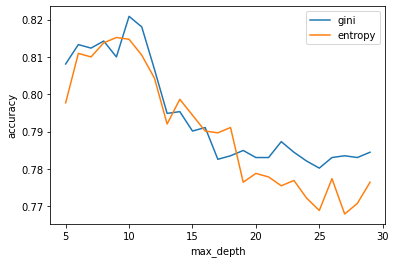

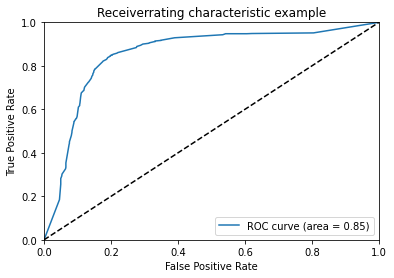

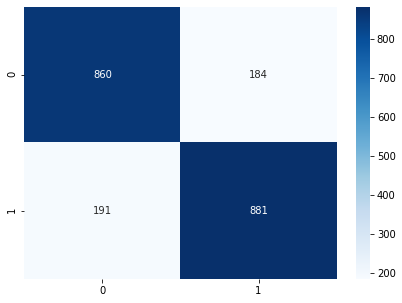

Accuracy: 0.8227788279773157
Precision: 0.8272300469483568
Recall: 0.8218283582089553
F1: 0.8245203556387459

------------------------------------------------------


Best criterion : entropy -  Best max depth : 10



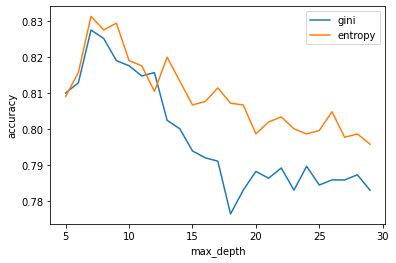

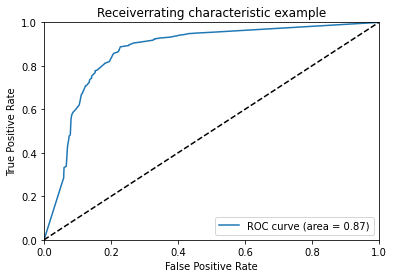

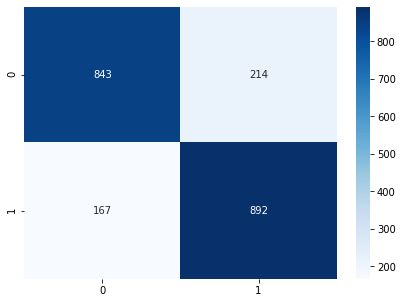

Accuracy: 0.8199432892249527
Precision: 0.8065099457504521
Recall: 0.842304060434372
F1: 0.8240184757505774

------------------------------------------------------


Best criterion : entropy -  Best max depth : 10



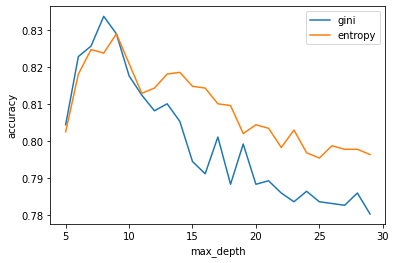

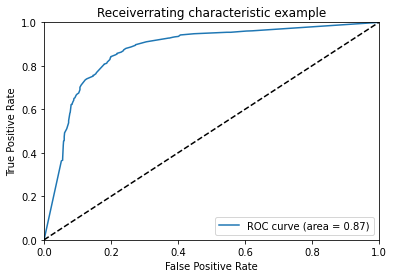

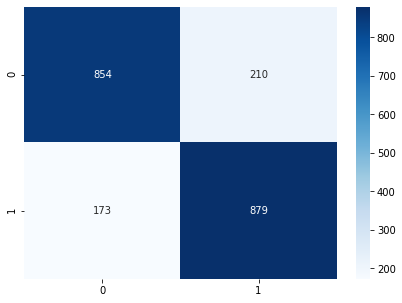

Accuracy: 0.8189981096408318
Precision: 0.8071625344352618
Recall: 0.8355513307984791
F1: 0.8211116300794022

------------------------------------------------------


Best criterion : entropy -  Best max depth : 10



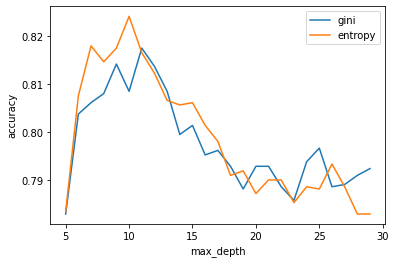

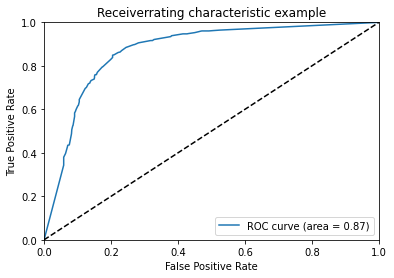

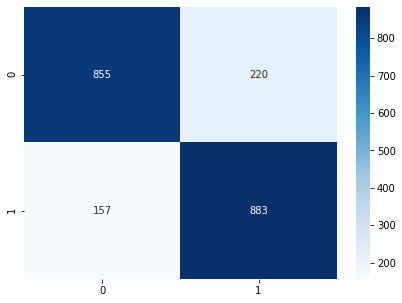

Accuracy: 0.8217494089834515
Precision: 0.800543970988214
Recall: 0.8490384615384615
F1: 0.8240783947736817

------------------------------------------------------


Best criterion : entropy -  Best max depth : 10



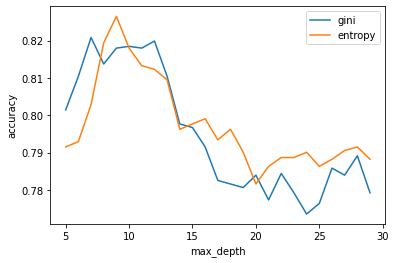

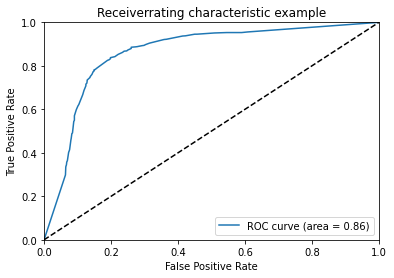

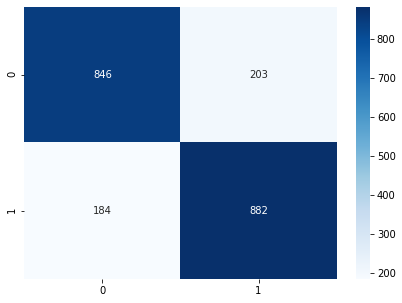

Accuracy: 0.8170212765957446
Precision: 0.8129032258064516
Recall: 0.8273921200750469
F1: 0.8200836820083681

------------------------------------------------------

Average Accuracy:0.8200981824844593
Average Precision:0.8108699447857471
Average Recall:0.835222866211063
Average F1:0.8227625076501551
Runtime Performance: 0:00:17.691929


In [ ]:
#implementation of polynomial SVM on leaf dataset
start=datetime.now()  #for runtime performance, timer starts.
desicionTree(bank_dataset, optimum_acc = 0.7)
print ("Runtime Performance:",datetime.now()-start) #sub the current time and start time to find runtime

**Comments**

Decision tree yielded similar results with SVM. 

# KD-trees


In [ ]:
#KNN Classifier
def kd_tree(trainingSet,testSet,k):  #finds k=5 nearerst neighbors for given test value.
    distance = 0
    distances = [] 
    neighbors = []
    length = len(testSet) 
    tree = KDTree(trainingSet)              
    nearest_dist, nearest_ind = tree.query([testSet], k=k) 

    distances = list(np.column_stack((nearest_ind[0], nearest_dist[0])))  
    
    for x in range(k):      # gets the first k elemnts of distances and adds to neihbors array
        neighbors.append(int(distances[x][0]))  #gets index value by increasing row value without distance value

    return neighbors


def getResult(neighbors,Y_train):   #with neigbors index value, neighbors class names are taken from Y_train. 
    classVotes = {}
    for x in range(len(neighbors)):
        index = neighbors[x]
        response = Y_train[index]
        if response in classVotes:    #classvotes shows the class names and how many niegbors are in the spesific class
            classVotes[response] += 1  #if there is already same class in classvotes, just increase the vote value
        
        else:
            classVotes[response] = 1  #if the class name couldn't find in the classvotes it creates class name and votes 1.
            
    sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)  #sort by their vote value
    return sortedVotes [0][0]


            
def knnClassifier(dataset):

    array = dataset.values   
    X = array[:,1:-1]
    Y = array[:,-1] 
    
    totalAccuracy = 0
    totalPrecision = 0
    totalRecall = 0
    totalf1 = 0
    
    kf = KFold(n_splits=5, random_state=None, shuffle=True) #k-fold cross validation with value 10.
    split = kf.get_n_splits(X)
    print(kf) 
    
    for train_index, test_index in kf.split(X):   #splits the data to train and test data by given k value.
        
        X_train, X_test = X[train_index], X[test_index]   
        Y_train, Y_test = Y[train_index], Y[test_index]

    
        k = 5
        predictions=[]

        for x in range(len(X_test)):
            
            neighbors = kd_tree(X_train, X_test[x], k)  #get neighbors
            result = getResult(neighbors,Y_train)   #get predicted class 
            predictions.append(result)    
            
        confMatrix = confusion_matrix(Y_test, predictions)   #make confusion matrix by predictions and the true result
        
        df_cm = pd.DataFrame(confMatrix)
        plt.figure(figsize = (7,5))
        sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues') 
        plt.show()

        accuracy = accuracy_score(Y_test, predictions)  
        totalAccuracy += accuracy
        precision = precision_score(Y_test, predictions)  
        totalPrecision += precision
        recall = recall_score(Y_test, predictions)  
        totalRecall += recall
        f1 = f1_score(Y_test, predictions)  
        totalf1 += f1
        
        print('Accuracy: ' + repr(accuracy))
        print('Precision: ' + repr(precision))
        print('Recall: ' + repr(recall))
        print('F1: ' + repr(f1))
        print('\n------------------------------------------------------\n')
    
    
    print('Average Accuracy:'+repr(totalAccuracy/split))
    print('Average Precision:'+repr(totalPrecision/split))
    print('Average Recall:'+repr(totalRecall/split))
    print('Average F1:'+repr(totalf1/split))
 

## Part 6

KFold(n_splits=5, random_state=None, shuffle=True)


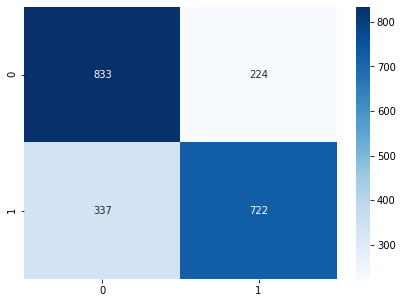

Accuracy: 0.7348771266540642
Precision: 0.7632135306553911
Recall: 0.6817752596789424
F1: 0.7201995012468827

------------------------------------------------------



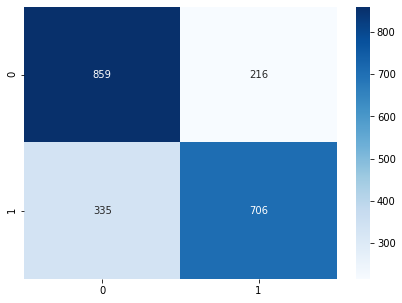

Accuracy: 0.7396030245746692
Precision: 0.7657266811279827
Recall: 0.6781940441882806
F1: 0.7193071828833418

------------------------------------------------------



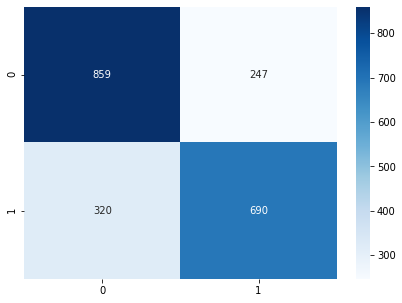

Accuracy: 0.7320415879017014
Precision: 0.736392742796158
Recall: 0.6831683168316832
F1: 0.7087827426810478

------------------------------------------------------



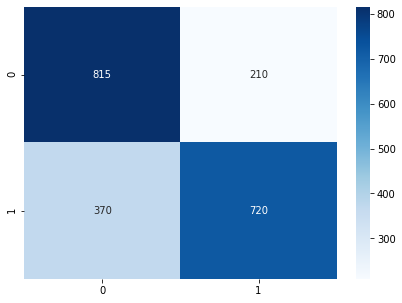

Accuracy: 0.7257683215130024
Precision: 0.7741935483870968
Recall: 0.6605504587155964
F1: 0.7128712871287128

------------------------------------------------------



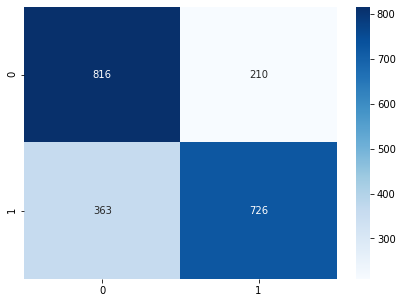

Accuracy: 0.7290780141843972
Precision: 0.7756410256410257
Recall: 0.6666666666666666
F1: 0.7170370370370369

------------------------------------------------------

Average Accuracy:0.7322736149655669
Average Precision:0.7630335057215308
Average Recall:0.6740709492162338
Average F1:0.7156395501954045
Runtime Performance: 0:05:05.407447


In [ ]:
#implementation of KNN on iris dataset with euclidean distance
start=datetime.now()  #for runtime performance, timer starts.
knnClassifier(bank_dataset)  #do knn classification for X data and Y target. 0 means do euclidean distance to calculate neigbors distance
print ("Runtime Performance:",datetime.now()-start) #sub the current time and start time to find runtime